Extração(LLM) - Recomendação (RecSys) - Review (LLM) 

## IMPORTS 

### Dataset

In [36]:
# import sys
# import platform

# print("--- Versão do Python e Módulos Nativos ---")
# # Módulos Nativos (não possuem __version__ próprio, usam a versão do Python)
# native_modules = ['zipfile', 'json', 're', 'asyncio']
# print(f"Python: {platform.python_version()}")
# print(f"Módulos Nativos (e.g., {', '.join(native_modules)}): Versão é a mesma do Python.")

# print("\n--- Versões de Bibliotecas de Terceiros ---")

# # Lista de bibliotecas para checar
# libraries_to_check = [
#     'numpy',
#     'pandas',
#     'scipy', # Checa scipy.sparse através do módulo pai scipy
#     'sklearn', # Checa sklearn e sklearn.model_selection
#     'implicit', # Checa implicit, implicit.als, implicit.bpr
#     'openai',
#     'matplotlib' # Exemplo de outra biblioteca comum
# ]

# for lib_name in libraries_to_check:
#     try:
#         # Importa a biblioteca dinamicamente
#         lib = __import__(lib_name)
        
#         # Acessa o atributo __version__ ou version
#         version = getattr(lib, '__version__', 'Versão não encontrada')
        
#         # Casos especiais onde a versão pode ser um sub-módulo
#         if lib_name == 'scipy':
#              print(f"{lib_name} (inclui scipy.sparse): {version}")
#         elif lib_name == 'sklearn':
#              print(f"{lib_name} (inclui sklearn.model_selection): {version}")
#         elif lib_name == 'implicit':
#              print(f"{lib_name} (inclui implicit.als e implicit.bpr): {version}")
#         else:
#             print(f"{lib_name:<15}: {version}")
        
#     except ImportError:
#         print(f"{lib_name:<15}: Não instalada")
#     except Exception as e:
#         print(f"{lib_name:<15}: Erro ao checar a versão ({e})")

In [3]:
import pandas as pd
import openai # API openai
import zipfile # Extrair .zip
import json # Trabalhar com JSON
import re


In [6]:
# Importando dados de treino e teste
with zipfile.ZipFile('../data/redial_dataset.zip', 'r') as z:
    z.extractall('../data/')

train_data = []
for line in open("../data/train_data.jsonl", "r"):
    train_data.append(json.loads(line))
print("Loaded {} train conversations".format(len(train_data)))


test_data = []
for line in open("../data/test_data.jsonl", "r"):
    test_data.append(json.loads(line))
print("Loaded {} test conversations".format(len(test_data)))

Loaded 10006 train conversations
Loaded 1342 test conversations


In [28]:
train_data[32]

{'movieMentions': {'127328': 'Hairspray  (2007)',
  '172129': 'Chicago 10  (2007)',
  '124268': 'Mamma Mia!  (2008)',
  '145997': 'Chicago  (2002)',
  '124461': 'White Christmas  (1954)',
  '107350': 'Sweeney Todd: The Demon Barber of Fleet Street  (2007)'},
 'respondentQuestions': {'127328': {'suggested': 0, 'seen': 1, 'liked': 1},
  '172129': {'suggested': 1, 'seen': 1, 'liked': 1},
  '124268': {'suggested': 1, 'seen': 0, 'liked': 1},
  '145997': {'suggested': 1, 'seen': 1, 'liked': 1},
  '124461': {'suggested': 1, 'seen': 1, 'liked': 1},
  '107350': {'suggested': 0, 'seen': 1, 'liked': 1}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi can you help me find a musical',
   'senderWorkerId': 1,
   'messageId': 1575},
  {'timeOffset': 2,
   'text': 'hey what kind of movies interest you',
   'senderWorkerId': 14,
   'messageId': 1576},
  {'timeOffset': 13,
   'text': 'yes i would love to!',
   'senderWorkerId': 14,
   'messageId': 1577},
  {'timeOffset': 60,
   'text': 'I really like @1

In [27]:
# Exemplo de conversa 
conversation = train_data[32]

# Mostrar de forma formatada
print("=== Conversa ID:", conversation["conversationId"], "===")
for msg in conversation["messages"]:
    sender = "Usuário 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "Usuário 2"
    print(f"{sender}: {msg['text']}")

=== Conversa ID: 485 ===
Usuário 1: Hi can you help me find a musical
Usuário 2: hey what kind of movies interest you
Usuário 2: yes i would love to!
Usuário 1: I really like @127328 and @107350
Usuário 2: have you seen @172129 with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
Usuário 2: I like @127328 too!
Usuário 2: oops, I meant @145997
Usuário 1: Yeah I have seen @145997 many times
Usuário 2: what about @124461 for something a little different or even @124268 which was more recent?
Usuário 1: I have not seen @124268 I think I may like that one
Usuário 2: The music is all from ABBA and it is so good
Usuário 2: I hope you will enjoy it as much as I do
Usuário 1: That is great that group does have some good music thanks for the help. Bye
Usuário 2: no problem bye


In [30]:
movie_mentions = conversation.get('movieMentions', {})

print(f"=== Conversa ID: {conversation['conversationId']} ===")

for msg in conversation["messages"]:
    sender = "Usuário 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "Usuário 2"
    text = msg['text']
    
    # Substitui cada @movieId pelo título do filme
    for movie_id, movie_title in movie_mentions.items():
        text = text.replace(f'@{movie_id}', movie_title)
    
    print(f"{sender}: {text}")

=== Conversa ID: 485 ===
Usuário 1: Hi can you help me find a musical
Usuário 2: hey what kind of movies interest you
Usuário 2: yes i would love to!
Usuário 1: I really like Hairspray  (2007) and Sweeney Todd: The Demon Barber of Fleet Street  (2007)
Usuário 2: have you seen Chicago 10  (2007) with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
Usuário 2: I like Hairspray  (2007) too!
Usuário 2: oops, I meant Chicago  (2002)
Usuário 1: Yeah I have seen Chicago  (2002) many times
Usuário 2: what about White Christmas  (1954) for something a little different or even Mamma Mia!  (2008) which was more recent?
Usuário 1: I have not seen Mamma Mia!  (2008) I think I may like that one
Usuário 2: The music is all from ABBA and it is so good
Usuário 2: I hope you will enjoy it as much as I do
Usuário 1: That is great that group does have some good music thanks for the help. Bye
Usuário 2: no problem bye


In [6]:
conversation = train_data[222]

# IDs de usuários
initiator_id = conversation["initiatorWorkerId"]
respondent_id = conversation["respondentWorkerId"]

print("ID do usuário que iniciou a conversa:", initiator_id)
print("ID do usuário que respondeu:", respondent_id)


ID do usuário que iniciou a conversa: 56
ID do usuário que respondeu: 60


In [7]:
#Filtrar outliers que assistiram muitos ou quase nenhum filmes?

## Tratamento e Limpeza dos datasets

In [9]:
def clean_data(dataset):
    """
    Remove diálogos inválidas do dataset 
    """

    invalid_indexes = []

    # Identifica diálogos inválidas
    for i, conv in enumerate(dataset):
        if (
            isinstance(conv.get("movieMentions"), list) # Se for lista em vez de dicionário
            or not isinstance(conv.get("movieMentions", {}), dict) # Se dicionário for inválido
            or "messages" not in conv # Diálogo sem mensagem
            or not conv["messages"] # Diálogo sem mensagem
        ):
            invalid_indexes.append(i)

    # Remove invalidos
    for i in sorted(invalid_indexes, reverse=True):
        del dataset[i]

    print(f"✅ Conversas válidas restantes: {len(dataset)}")
    print(f"🗑️ Conversas removidas: {len(invalid_indexes)}")

clean_data(train_data)
clean_data(test_data)

✅ Conversas válidas restantes: 10005
🗑️ Conversas removidas: 0
✅ Conversas válidas restantes: 1342
🗑️ Conversas removidas: 0


## Extração de itens e Montagem Matriz Usuário-Item (LLM)

In [9]:
#!pip install openai
#!pip install implicit


### API LLM

In [37]:
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable


In [40]:
from dotenv import load_dotenv
import os

load_dotenv() 
API_KEY = os.getenv("API_KEY")


In [41]:
from openai import OpenAI
import asyncio
from openai import AsyncOpenAI


client = OpenAI(api_key=API_KEY)
client_async = AsyncOpenAI(api_key=API_KEY)

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "oi, digite 112233 e uma frase qualquer"}
    ]
)

print(response.choices[0].message.content)




112233

A vida é feita de momentos, aproveite cada um deles!


### Extração Itens

#### Funções 

In [ ]:
# Extração e atitude de user/item

# Formata cada dialogo de JSON para string, separando usuário de sistema 
def format_conversation(conv):

    """
    Formata cada dialogo de JSON para string, separando usuário de sistema 
    """

    msgs = []
    for msg in conv["messages"]:
        sender = "User" if msg["senderWorkerId"] == conv["initiatorWorkerId"] else "System"
        msgs.append(f"{sender}: {msg['text']}")
    return "\n".join(msgs)



def prompt_extraction_items(conv):

    """
    Gera o prompt que será enviado à LLM para extrair os filmes e atribuir ratings (1 a 5) apropriadas de acordo com a atitude do usuário.
    conversation_text = Dialogo
    mentioned_ids = IDs dos filmes mencionados
    filtered_mentions = Mantem apenas os IDs que aparecem na conversa 
    movie_mentions = String com o nome de filmes mencionados
    """

    conversation_text = format_conversation(conv)
    mentioned_ids = re.findall(r'@(\d+)', conversation_text)
    filtered_mentions = {k: v for k, v in conv["movieMentions"].items() if k in mentioned_ids}
    movie_mentions = "\n".join([f"@{k} = {v}" for k, v in filtered_mentions.items()])


#     prompt = f"""
# Pretend you are a movie recommender system. You (a
# recommender system) will be given a full conversation between a user
# and a system. Based on the entire conversation, you need to extract ALL 
# movie names mentioned and analyze the user's final attitude toward each movie.
# You need to reply with standardized movie names (with grammatical errors corrected 
# and abbreviations fixed), as well as the user's attitude toward the movie.


# Movies in the conversation are referred to by tokens like "@12345". The
# user's final attitude toward each movie is represented in one of 
# [1, 2, 3, 4, 5], where 1 stands for very negative, 2 stands for 
# negative, 3 stands for neutral, 4 stands for positive, and 5 stands for 
# very positive. You need to reply with the number as an attitude instead 
# of the textual description. If there are movie names mentioned in the query,
# list each movie name and the user's attitude (number in 0 to
# 5) in the form of movie_name####attitude, where different
# movies are listed in different lines with no extra sentences.
# Reply NO if no movie names are mentioned in the query.

# Use the following mapping to know which movie each token refers to:
# {movie_mentions}

# Important: ONLY consider movies explicitly mentioned (tokens starting with '@'). 
# Do NOT include any other movies even if related or implied.
# If you include any movie not mentioned, your answer will be invalid.

# Conversation:
# {conversation_text}
# """

    prompt = f"""
Pretend you are a movie recommender system. You (a
recommender system) will be given a full conversation between a user
and a system. Based on the entire conversation, you need to extract ALL 
movie ids mentioned and analyze the user's final attitude toward each movie.
You need to reply with movie ids as well as the user's attitude toward the movie.


Movies in the conversation are referred to by tokens like "@12345". The
user's final attitude toward each movie is represented in one of 
[1, 2, 3, 4, 5], where 1 stands for very negative, 2 stands for 
negative, 3 stands for neutral, 4 stands for positive, and 5 stands for 
very positive. You need to reply with the number as an attitude instead 
of the textual description. If there are movie ids mentioned in the query,
list each movie id and the user's attitude (number in 0 to
5) in the form of movie_id####attitude, where different
movies are listed in different lines with no extra sentences.
You must reply ONLY with movie IDs (e.g., 122159), not movie names.
You mus remove the "@" that comes in the beginning of the movie id.


Use the following to know which movie each token refers to:
{movie_mentions}

Important: ONLY consider movies explicitly mentioned (tokens starting with '@'). 
Do NOT include any other movies even if related or implied.
If you include any movie not mentioned, your answer will be invalid.

Conversation:
{conversation_text}

Example output format:
122159####5
84779####4
"""
    return prompt.strip()



def extract_user_movie_rating(conv, llm_response):

    """
    Extrai userId, movieId e rating a partir da resposta da LLM
    """

    user_id = conv["initiatorWorkerId"]
    lines = llm_response.strip().splitlines()
    data = []

    for line in lines:
        if "####" in line:
            movie_id, rating = line.split("####")

            data.append({
                "userId": user_id,
                "movieId": int(movie_id.strip()),
                "rating": int(rating.strip())
            })

    return pd.DataFrame(data)


#### SYNC

In [31]:
# Testar com uma conversa
conv_35 = train_data[35]

# Montagem prompt extração item/rating
prompt = prompt_extraction_items(conv_35)

# Resposta LLM
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0
)

print("=== PROMPT ===")
print(prompt)

print("\n=== RESPOSTA ===")
print(response.choices[0].message.content.strip())


# Exemplo com resposta exemplo
llm_response = response.choices[0].message.content.strip()

# Extrai user/item/rating
df_result = extract_user_movie_rating(conv_35, llm_response)

print(df_result)

=== PROMPT ===
Pretend you are a movie recommender system. You (a
recommender system) will be given a full conversation between a user
and a system. Based on the entire conversation, you need to extract ALL 
movie ids mentioned and analyze the user's final attitude toward each movie.
You need to reply with movie ids as well as the user's attitude toward the movie.


Movies in the conversation are referred to by tokens like "@12345". The
user's final attitude toward each movie is represented in one of 
[1, 2, 3, 4, 5], where 1 stands for very negative, 2 stands for 
negative, 3 stands for neutral, 4 stands for positive, and 5 stands for 
very positive. You need to reply with the number as an attitude instead 
of the textual description. If there are movie ids mentioned in the query,
list each movie id and the user's attitude (number in 0 to
5) in the form of movie_id####attitude, where different
movies are listed in different lines with no extra sentences.
You must reply ONLY with movie

#### ASYNC

In [12]:
# Execução Assíncrona

async def process_conversation(conv):

    """
    Processa um único diálogo
    """

    prompt = prompt_extraction_items(conv) # Gera prompt

    for attempt in range(3):  # tenta até 3 vezes
        try:
            # Chamada LLM
            response = await client_async.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )

            # Resosta LLM
            content = response.choices[0].message.content.strip()
            if content != "NO":
                return extract_user_movie_rating(conv, content) # Input para matriz usuário item com ratings
            break
        except Exception as e:
            await asyncio.sleep(2) 
    return pd.DataFrame(columns=["userId", "movieId", "rating"]) # Fallback


async def process_dataset(sample_data, batch_size=10):
    """
    Processa vários diálogos em paralelo (batch)
    """
    results = []
    for i in range(0, len(sample_data), batch_size): # Divide dataset em batches
        batch = sample_data[i:i+batch_size]
        tasks = [process_conversation(conv) for conv in batch] # Para cada diálogo no batch, calcula input da matriz
        batch_results = await asyncio.gather(*tasks) # Garante execução em paralelo 
        await asyncio.sleep(2) # evita timeout
        results.extend(batch_results)
        print(f" Processados {i+len(batch)} diálogos")

    df_all = pd.concat(results, ignore_index=True)
    return df_all #Matriz usuário item com ratings



In [13]:
user_item_train = await process_dataset(train_data, batch_size=40)


 Processados 40 diálogos
 Processados 80 diálogos
 Processados 120 diálogos
 Processados 160 diálogos
 Processados 200 diálogos
 Processados 240 diálogos
 Processados 280 diálogos
 Processados 320 diálogos
 Processados 360 diálogos
 Processados 400 diálogos
 Processados 440 diálogos
 Processados 480 diálogos
 Processados 520 diálogos
 Processados 560 diálogos
 Processados 600 diálogos
 Processados 640 diálogos
 Processados 680 diálogos
 Processados 720 diálogos
 Processados 760 diálogos
 Processados 800 diálogos
 Processados 840 diálogos
 Processados 880 diálogos
 Processados 920 diálogos
 Processados 960 diálogos
 Processados 1000 diálogos
 Processados 1040 diálogos
 Processados 1080 diálogos
 Processados 1120 diálogos
 Processados 1160 diálogos
 Processados 1200 diálogos
 Processados 1240 diálogos
 Processados 1280 diálogos
 Processados 1320 diálogos
 Processados 1360 diálogos
 Processados 1400 diálogos
 Processados 1440 diálogos
 Processados 1480 diálogos
 Processados 1520 diálogos


In [25]:
user_item_train.to_csv("user_item_train.csv", index=False, sep=";")
user_item_train

,userId,movieId,rating
0,0,84779,4
1,0,191602,4
2,0,122159,4
3,0,151313,4
4,0,203371,4
...,...,...,...
31814,953,204974,5
31815,954,85036,4
31816,954,170277,4
31817,954,149938,3


In [15]:
user_item_test = await process_dataset(test_data, batch_size=30)


 Processados 30 diálogos
 Processados 60 diálogos
 Processados 90 diálogos
 Processados 120 diálogos
 Processados 150 diálogos
 Processados 180 diálogos
 Processados 210 diálogos
 Processados 240 diálogos
 Processados 270 diálogos
 Processados 300 diálogos
 Processados 330 diálogos
 Processados 360 diálogos
 Processados 390 diálogos
 Processados 420 diálogos
 Processados 450 diálogos
 Processados 480 diálogos
 Processados 510 diálogos
 Processados 540 diálogos
 Processados 570 diálogos
 Processados 600 diálogos
 Processados 630 diálogos
 Processados 660 diálogos
 Processados 690 diálogos
 Processados 720 diálogos
 Processados 750 diálogos
 Processados 780 diálogos
 Processados 810 diálogos
 Processados 840 diálogos
 Processados 870 diálogos
 Processados 900 diálogos
 Processados 930 diálogos
 Processados 960 diálogos
 Processados 990 diálogos
 Processados 1020 diálogos
 Processados 1050 diálogos
 Processados 1080 diálogos
 Processados 1110 diálogos
 Processados 1140 diálogos
 Processad

In [23]:
user_item_test.to_csv("user_item_test.csv", index=False, sep=";")
user_item_test 

,userId,movieId,rating
0,956,111776,3
1,956,151656,4
2,956,192131,3
3,956,134643,3
4,956,94688,4
...,...,...,...
1721,1084,204870,4
1722,1084,95785,4
1723,1084,205724,4
1724,1084,90248,5


In [4]:
user_item_train = pd.read_csv("../data/user_item_train.csv", sep = ';')
user_item_test = pd.read_csv("../data/user_item_test.csv", sep = ';')


### Matrix Factorization

In [5]:
import numpy as np
from scipy.sparse import csr_matrix



def create_sparse_matrix(df, user_mapper, movie_mapper, shape):
    """Cria matriz esparsa a partir de DataFrame"""

    df_mapped = df.copy()

    #Faz mapeamento pois matrizes esparsas só aceitam índices inteiros começando em 0, e nao podem ser enormes
    df_mapped['user_index'] = df_mapped['userId'].map(user_mapper)#.astype('Int64')
    df_mapped['movie_index'] = df_mapped['movieId'].map(movie_mapper)#.astype('Int64')
    
    # remove linhas com NaN em índices ou rating inválido
    df_mapped = df_mapped.dropna(subset=['user_index', 'movie_index', 'rating'])
    df_mapped = df_mapped[df_mapped['rating'] > 0]

    # Remove duplicatas
    df_mapped = df_mapped.drop_duplicates(subset=['user_index', 'movie_index'], keep='last')
    
    # Cria matriz esparsa
    matrix = csr_matrix(
        (df_mapped['rating'].astype(float),
         (df_mapped['user_index'], #.astype('Int64')
          df_mapped['movie_index'])),#.astype('Int64')
        shape=shape
    )
    return matrix

def split_train_validation(user_item_matrix, validation_ratio=0.2, seed=42):
    """
    Divide uma matriz esparsa user-item em treino e validação.
    Retorna duas matrizes CSR (train, validation)
    """
    np.random.seed(seed)

    coo = user_item_matrix.tocoo()

    # embaralha índices
    indices = np.arange(len(coo.data))
    np.random.shuffle(indices)

    split = int(len(indices) * (1 - validation_ratio))
    train_idx, val_idx = indices[:split], indices[split:]

    train = csr_matrix((coo.data[train_idx], (coo.row[train_idx], coo.col[train_idx])),
                       shape=coo.shape)
    val = csr_matrix((coo.data[val_idx], (coo.row[val_idx], coo.col[val_idx])),
                     shape=coo.shape)
    return train, val


# def split_train_validation(matrix, validation_ratio=0.2, seed=42):
#     """
#     Divide matriz esparsa sem remover usuários.
#     Remove apenas ALGUMAS interações da matriz de treino.
#     """
#     np.random.seed(seed)

#     matrix = matrix.tolil()
#     val = lil_matrix(matrix.shape)

#     rows, cols = matrix.nonzero()
#     nnz = len(rows)
#     n_val = int(nnz * validation_ratio)

#     idx = np.random.choice(nnz, n_val, replace=False)

#     for k in idx:
#         i, j = rows[k], cols[k]
#         val[i, j] = matrix[i, j]
#         matrix[i, j] = 0

#     return matrix.tocsr(), val.tocsr()


In [6]:
#Utility matrix (user-item)

np.random.seed(42)

all_data = pd.concat([user_item_train, user_item_test]) # Concatena train + test para garantir que todos os IDs estejam mapeados

# user_mapper = {u: i for i, u in enumerate(all_data['userId'].unique())}
# movie_mapper = {m: i for i, m in enumerate(all_data['movieId'].unique())}

user_ids = sorted(all_data['userId'].unique())
movie_ids = sorted(all_data['movieId'].unique())

user_mapper = {u: i for i, u in enumerate(user_ids)}
movie_mapper = {m: i for i, m in enumerate(movie_ids)}

n_users = len(user_mapper)
n_movies = len(movie_mapper)



train_matrix = create_sparse_matrix(user_item_train, user_mapper, movie_mapper, (n_users, n_movies))
test_matrix = create_sparse_matrix(user_item_test, user_mapper, movie_mapper, (n_users, n_movies))

#Divide treino em treino/validação
#train_final_matrix, val_matrix = split_train_validation(train_matrix, validation_ratio=0.2, seed=42)




## Estrutura Final
# Dados Originais
#     ↓
# ├── user_item_train (80%)
# │   ├── train_final_matrix (64% do total)  ← Treina modelo aqui
# │   └── val_matrix (16% do total)          ← Ajusta hiperparâmetros aqui
# │
# └── user_item_test (20%)
#     └── test_matrix (20% do total)         ← Avaliação final aqui

In [61]:
import pandas as pd

# Limitar apenas aos primeiros 10 usuários e 10 filmes
small_matrix = train_matrix[:10, :6].toarray()

# Converter para DataFrame só para visualizar melhor
df_view = pd.DataFrame(small_matrix, columns=[f"Movie_{i}" for i in range(6)])
df_view.index = [f"User_{i}" for i in range(10)]

print(df_view)



        Movie_0  Movie_1  Movie_2  Movie_3  Movie_4  Movie_5
User_0      0.0      0.0      0.0      0.0      0.0      0.0
User_1      0.0      0.0      0.0      0.0      0.0      0.0
User_2      0.0      0.0      0.0      0.0      0.0      0.0
User_3      0.0      0.0      0.0      0.0      0.0      0.0
User_4      0.0      0.0      0.0      0.0      0.0      0.0
User_5      0.0      0.0      0.0      0.0      0.0      0.0
User_6      0.0      0.0      0.0      0.0      0.0      0.0
User_7      0.0      0.0      0.0      0.0      0.0      0.0
User_8      0.0      0.0      0.0      0.0      0.0      0.0
User_9      0.0      0.0      0.0      0.0      0.0      0.0


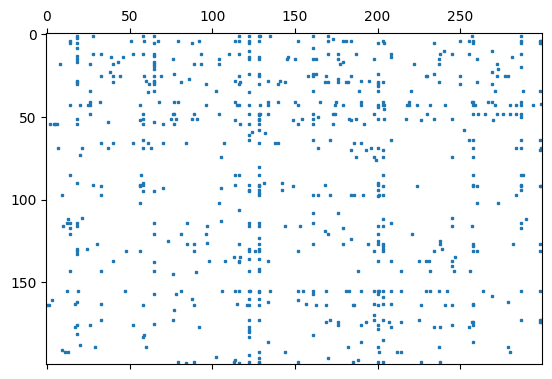

In [62]:
import matplotlib.pyplot as plt
plt.spy(train_matrix[:200, :300], markersize=2)
plt.show()


### Normalização

## Treinamento Modelo

In [20]:
#from pyspark.ml.recommendation import ALS

#!pip install cmake ninja
#!pip install --no-cache-dir implicit


#### ALS (Alternating Least Squares)

In [23]:
#csr_matrix
#Split train validation
#Grid search
#Model
#Recall@k


from implicit.als import AlternatingLeastSquares


def get_implicit_als(dataset, regularization, alpha_parameter, iterations, factors, random_state):
    """Gets results from ALS algorithm implementation from implicit library.

    Parameters
    ----------
    dataset:
        Training dataset.
    regularization:
        Regularization parameter (used for creating regularization term).
    alpha_parameter:
        Alpha parameter (used for creating confidence matrix).
    iterations:
        Number of iterations.
    factors:
        Number of user and item factors.
    random_state:
        Random state for feature vector initialization.

    Returns
    -------
        user_matrix, item_matrix: Matrices with feature vectors for users and items.
    """
    model = AlternatingLeastSquares(factors=factors,
                                    regularization=regularization,
                                    iterations=iterations,
                                    use_native=False)
    model.fit((dataset * alpha_parameter).astype('double'))

    return model.item_factors, model.user_factors





C:\Users\prude\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from implicit.als import AlternatingLeastSquares

model = AlternatingLeastSquares(
    factors=64,
    regularization=0.1,
    iterations=20
)

model.fit(train_matrix)

print("user factors:", model.user_factors.shape)
print("item factors:", model.item_factors.shape)


100%|██████████| 20/20 [00:00<00:00, 104.16it/s]

user factors: (594, 64)
item factors: (4922, 64)


In [21]:
real_user = 0
internal = int(user_mapper[real_user])

# matriz 1xN, não NxM
user_items_row = train_matrix[internal, :].tocsr()

scores, items = model.recommend(
    internal,
    user_items_row,
    N=10
)

print(items, scores)


[0.11403452 0.10054813 0.09822387 0.09508895 0.0946505  0.09028616
 0.08800226 0.08693253 0.08374397 0.08290876] [ 318 4802 4189  687 2885 4014 4792 2752 2303 2095]


In [ ]:
from sklearn.model_selection import ParameterGrid
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.model_selection import ParameterGrid
from implicit.als import AlternatingLeastSquares
import numpy as np

def recall_at_k(model, train_matrix, test_matrix, K=10):
    """Calcula Recall@K para as matrizes já montadas."""
    n_users, _ = train_matrix.shape
    recalls = []
    
    for user in range(n_users):
        seen_items = train_matrix[user].indices
        scores = model.user_factors[user].dot(model.item_factors.T)
        scores[seen_items] = -np.inf  # ignora itens já vistos
        top_k = np.argpartition(scores, -K)[-K:]
        
        test_items = test_matrix[user].indices
        if len(test_items) == 0:
            continue
        
        hits = np.isin(top_k, test_items).sum()
        recalls.append(hits / len(test_items))
    
    return np.mean(recalls)

# ----- Grid Search -----

param_grid = {
    'factors': [50, 100, 150],
    'regularization': [0.01, 0.1, 1.0],
    'iterations': [10, 20],
    'alpha': [10, 40]
}

best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Treinando com parâmetros: {params}")
    
    model = AlternatingLeastSquares(
        factors=params['factors'],
        regularization=params['regularization'],
        iterations=params['iterations'],
        use_gpu=False
    )
    
    model.fit((user_item_train * params['alpha']).astype('double'))
    score = recall_at_k(model, user_item_train, user_item_test, K=10)
    
    print(f"Recall@10 = {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_params = params

print("\nMelhores parâmetros encontrados:")
print(best_params)
print(f"Melhor Recall@10: {best_score:.4f}")


In [ ]:
from pyspark.ml.recommendation import ALS

als = ALS(userCol = "userId", itemCol = "movieId", labelCol = "rating", coldStartStrategy = "drop", nonegative = True)

#### BPR (Bayesian Personalized Ranking)

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking